# Convolutional neural networks

## Importing libraries and helper functions.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Importing helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2.8.0


In [ ]:
# Conecting to the Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Visualization helper function

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()


## Loading the data

In the code below, data is loded. The option 'coarse' selects the 20-coarse class version (instead of the 100-class version).

In [ ]:
# Loading the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), (x_test, r_test_class) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 6000
# splitting off the validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# Taking a subset of the training data first, for exploration
x_train_small = x_train[:20000]
r_train_small_class = r_train_class[:20000]

# performing standardization
x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0
x_test /= 255.0

# the labels from the downloaded data are integer numbers
# since this is a multi-class classification task, I convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)
r_test = tf.keras.utils.to_categorical(r_test_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')



x_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples
x_test shape: (10000, 32, 32, 3)
10000 test samples


Visualizing a few examples of the training data:



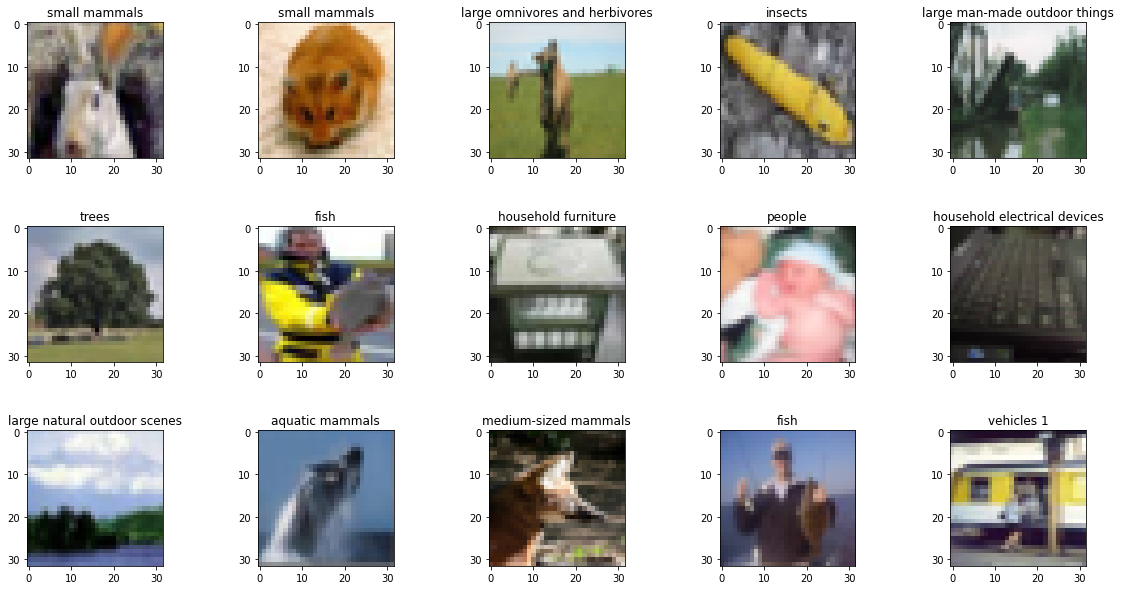

In [ ]:
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[r_train_class[idx,0]])
    plt.imshow(x_train[idx],  interpolation='None')

## An initial model showing the stucture on the CNN



In [ ]:


def initial_model():
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(128, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(4, 4)))
  model.add(Dropout(0.4))

  # end of convolutional layers, start of the'hidden' dense layers
  model.add(Flatten())

  model.add(Dense(512, kernel_constraint=max_norm()))
  model.add(Activation('relu'))

  # Final dense layer = linear classifier
  model.add(Dense(num_classes, kernel_constraint=max_norm()))
  model.add(Activation('softmax'))

  opt = tf.keras.optimizers.Adam(learning_rate=0.0003)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                          

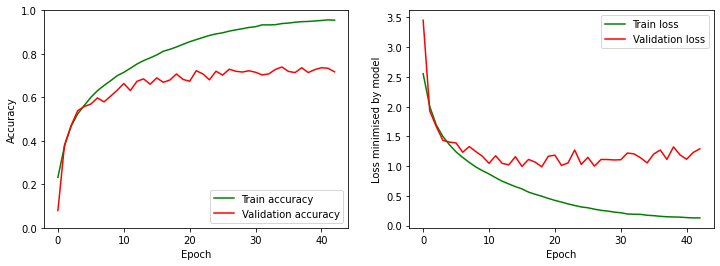

In [ ]:
batch_size = 128
epochs = 50

# introducing checkpoints and early stopping

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2022/project/"
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"prjt_deeper.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"


model_1 = initial_model()
model_1.summary()

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,min_delta=0.0001)

history_1 = model_1.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
          callbacks = [cp_callback, stopping_callback],
          shuffle=True)

# Realising the result:
[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

# visualizing what happened during training
plot_history(history_1)

**Analyzing the best model **

In [ ]:
import pathlib

# Finding the latest checkpoints
# Sorting the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)
checkpoints

/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0035.ckpt


[PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0021.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0008.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0012.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0018.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0020.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0023.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0024.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0025.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0033.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0034.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0036.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2022/GA2/cp-0015.ckpt'),
 PosixPath('/content/gdrive/My Drive/Col

In [ ]:
# Restoring the model

best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below gives slightly better results than the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

Training set Accuracy: 0.9851
Training set Loss:0.058609

Validation set Accuracy: 0.7395
Validation set Loss:1.055464



## 3. Augmentation

Having a look at some augmented images before applying augmentation.

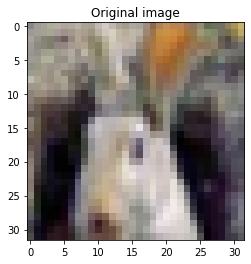

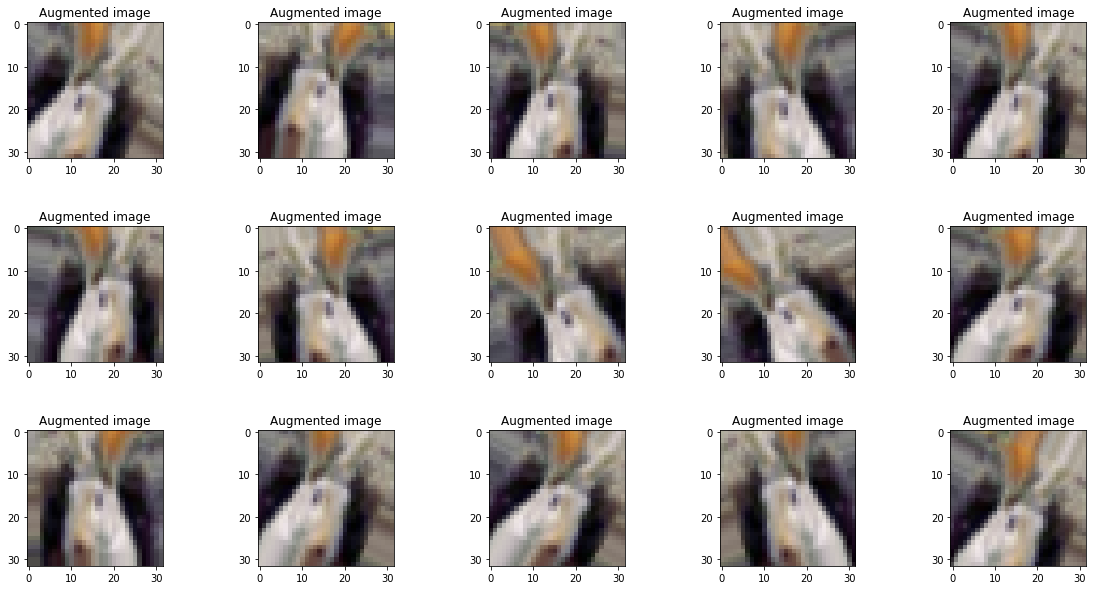

In [ ]:
# An object from the class ImageDataGenerator will perform 'on-the-fly' data augmentation
# every time I call its function .flow()

datagen = ImageDataGenerator(
        rotation_range=30.0,  # randomly rotating images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shifting images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shifting images vertically (fraction of total height)
        horizontal_flip=True,  # randomly fliping images
        vertical_flip=False,  # randomly fliping images
        fill_mode = 'nearest',
        zoom_range = 0.1)

# selecting and displaying an image from the training set
img_index = 0

plt.figure()
plt.imshow(x_train[img_index],  interpolation='None')
plt.title("Original image")
plt.show()

testit = datagen.flow(x_train[img_index:img_index+1], batch_size=1)

# generating 15 augmented images (the first one being the original image)
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Augmented image")
    plt.imshow(testit.next()[0,:,:,:],  interpolation='None')
plt.show()



In [ ]:
batch_size = 128
epochs = 50

au_model = initial_model()
au_model.summary()
au_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# dummy file path here
filepath = 'save_my_au_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', patience=8),
             ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)]

datagen = ImageDataGenerator(
        rotation_range=30.0,  # randomly rotating images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shifting images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shifting images vertically (fraction of total height)
        horizontal_flip=True,  # randomly fliping images
        vertical_flip=False,  # randomly fliping images
        fill_mode = 'nearest',
        zoom_range = 0.1)

# Computing quantities required for some augmentation functions
datagen.fit(x_train, augment=True)

# Fiting the model on the batches generated by datagen.flow().
au_history = au_model.fit(datagen.flow(x_train, r_train, batch_size=batch_size),
                                    epochs=epochs, steps_per_epoch=len(x_train) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = callbacks)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_41 (Activation)  (None, 32, 32, 128)      

By running the code below, I compare the condition with and without augmentation (or any two situations ...).

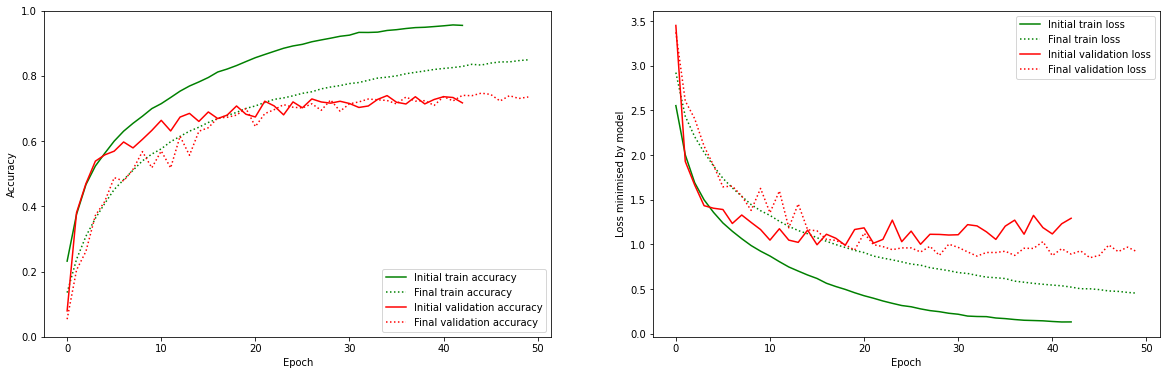

In [ ]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()


plot_dual_history(history_1,au_history)


# Analysis

In [ ]:
# The code below gives the same results as that for the original model
[train_loss, train_accuracy] = au_model.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = au_model.evaluate(x_test, r_test, verbose=0)
print("Test set Accuracy:{:7.4f}".format(test_accuracy))
print("Test set Loss:{:7.6f}\n".format(test_loss))

Training set Accuracy: 0.8858
Training set Loss:0.344111

Test set Accuracy: 0.7387
Test set Loss:0.910214



In [ ]:
predictions = au_model.predict(x_test)

# the predictions are class probabilities,
# the argmax code line below finds the index of the class with the highest probability

test_predicted_class = np.argmax(predictions,axis=1)
misclassified = np.where(test_predicted_class!=r_test_class[:,0])[0]

# misclassified is a vector that contains the indices of all misclassified samples

print("There are ",misclassified.shape[0]," misclassified samples in the test set.")

There are  2613  misclassified samples in the test set.


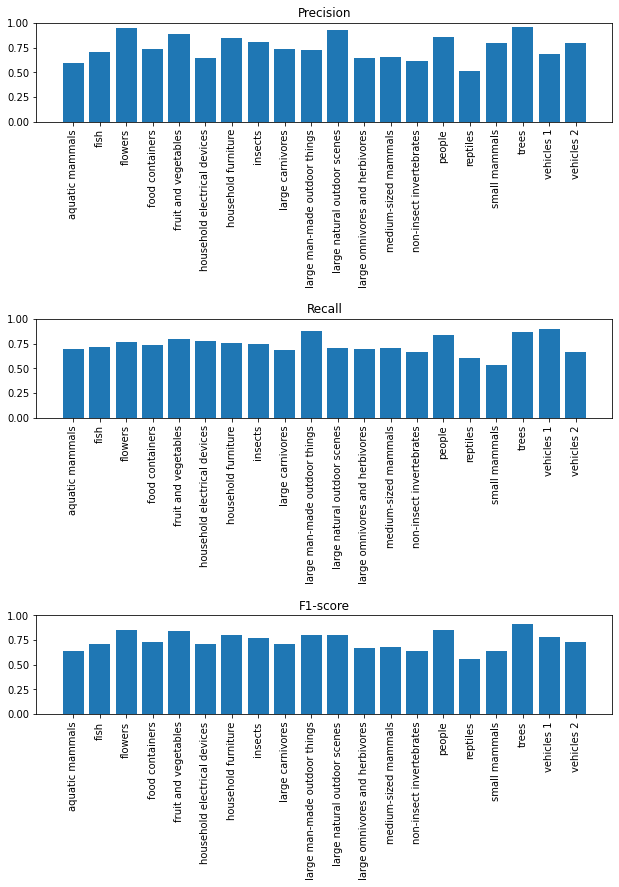

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, f1, _ = score(r_test_class, test_predicted_class)

names = labels
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.bar(names, precision)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylim([0,1])
plt.title("Precision")
plt.subplot(3,1,2)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.bar(names, recall)
plt.title("Recall")
plt.ylim([0,1])
plt.subplot(3,1,3)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.bar(names, f1)
plt.ylim([0,1])
plt.title("F1-score")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=2.0)
plt.show()


The first 9 misclassified samples look like this:


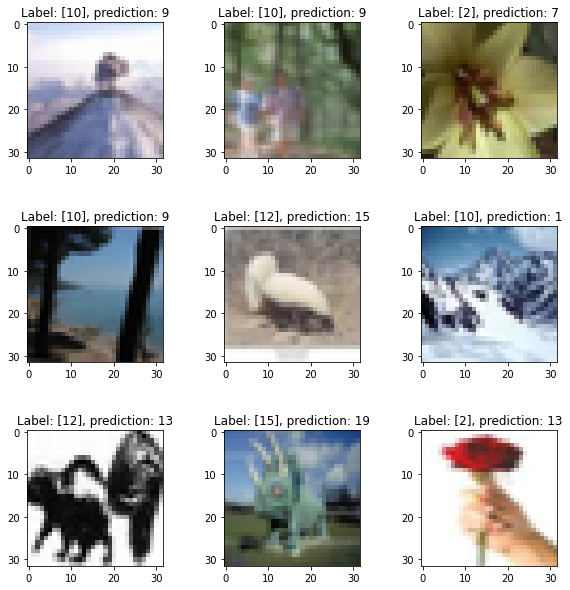

In [ ]:
print("The first 9 misclassified samples look like this:")

f = plt.figure(figsize=(10,10));
for idx in range(9):
    mis_index = misclassified[idx]
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label: " + str(r_test_class[mis_index])
              + ", prediction: " + str(test_predicted_class[mis_index]))
    plt.imshow(np.reshape(x_test[mis_index,:],(32,32,3)), interpolation='None')

In [ ]:
# The functions below were borrowed/adapted from the notebook:
# https://www.tensorflow.org/tutorials/keras/classification


# Plotting the image with some annotations
def plot_image(predictions, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions),
                                true_label),
                                color=color)


# showing the predictions for the plotted sample
def plot_value_array(predictions, true_label):
  plt.grid(False)
  plt.xticks(range(20))
  plt.yticks([])
  thisplot = plt.bar(range(20), predictions, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions)


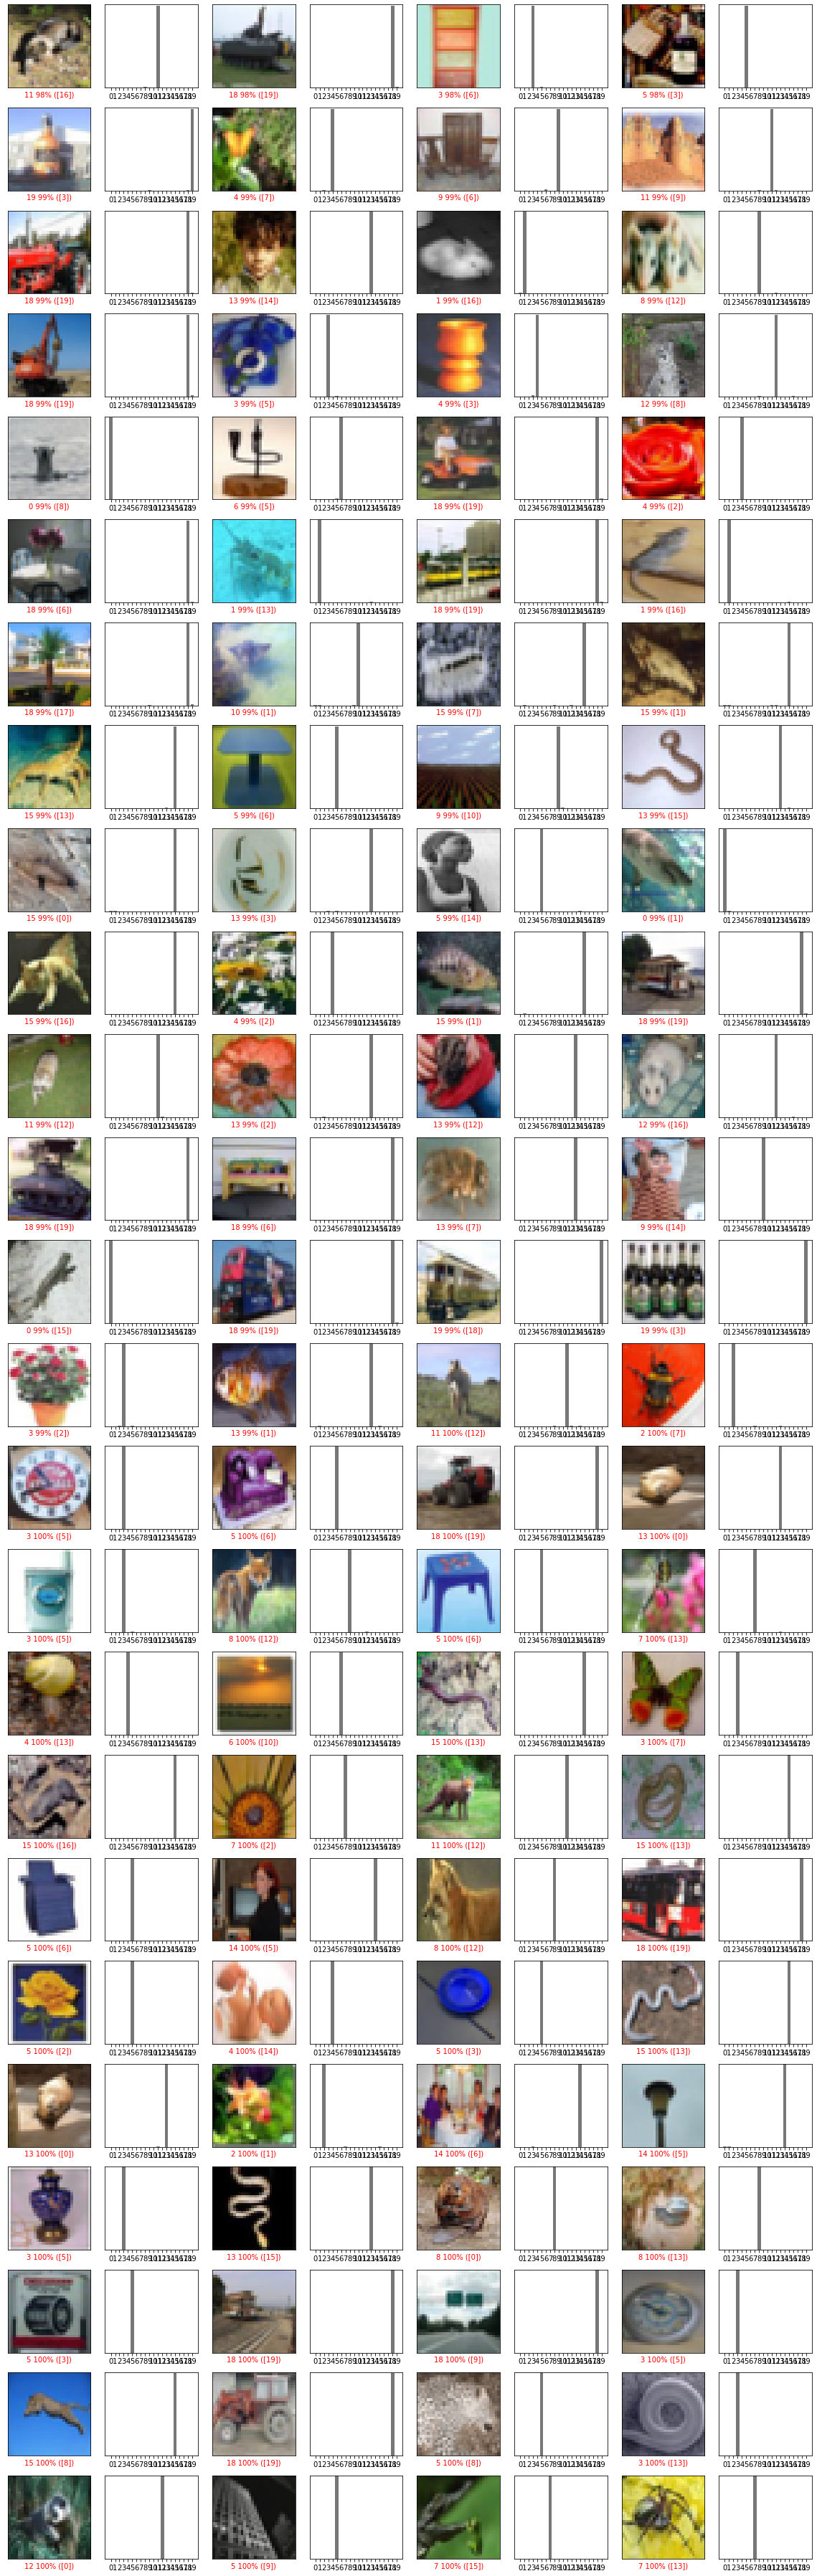

In [ ]:
# probabilities for class that will be predicted
maxprob = np.max(predictions, axis=1)

# finding 100 most certain misclassified samples
most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-100:]]


# Plotting the first X test images, their predicted labels, and the true labels.
# Coloring correct predictions in blue and incorrect predictions in red.
num_rows = 25
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  idx=most_certain[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[idx], r_test_class[idx], np.reshape(x_test[idx],(32,32,3)))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[idx], r_test_class[idx])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrix(true_labels, predictions,
                          classes =[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Function plotting the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    code adapted from
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)

    # overriding diag. values
    np.fill_diagonal(cm,0)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


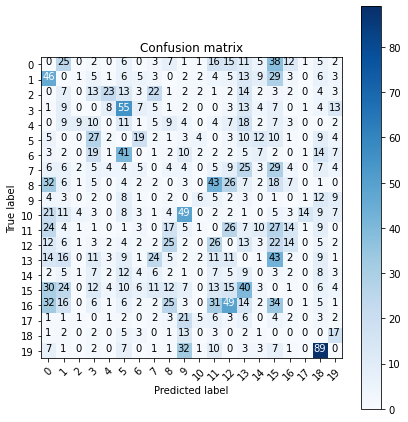

In [ ]:
plot_confusion_matrix(r_test_class, test_predicted_class)